In [91]:
from itertools import combinations

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.inspection import DecisionBoundaryDisplay 
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import svm

from matplotlib.gridspec import GridSpec
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [92]:
iris = load_iris(as_frame = True)

df = iris['data']
df.columns = ['s_length', 's_width', 'p_length', 'p_width']

full_df = df.copy()
full_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

df

,s_length,s_width,p_length,p_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## Задание 1

<Axes: >

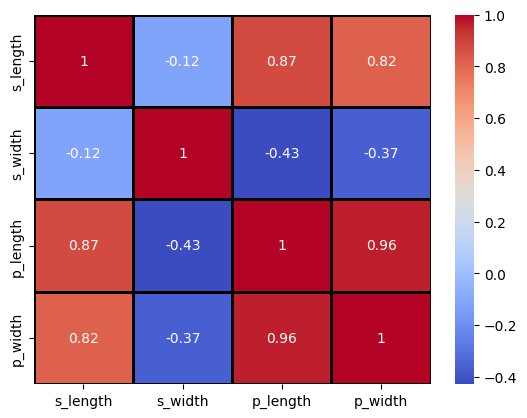

In [93]:
sns.heatmap(df.corr(), cmap = 'coolwarm', linewidths = 2, linecolor = 'black', annot = True)

<Axes: ylabel='species-None'>

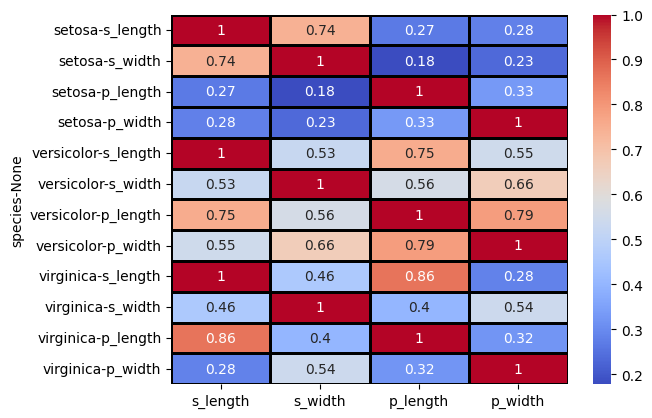

In [94]:
df_groups = df.groupby(full_df['species'], observed = True)
sns.heatmap(df_groups.corr(), cmap = 'coolwarm', linewidths = 2, linecolor = 'black', annot = True)

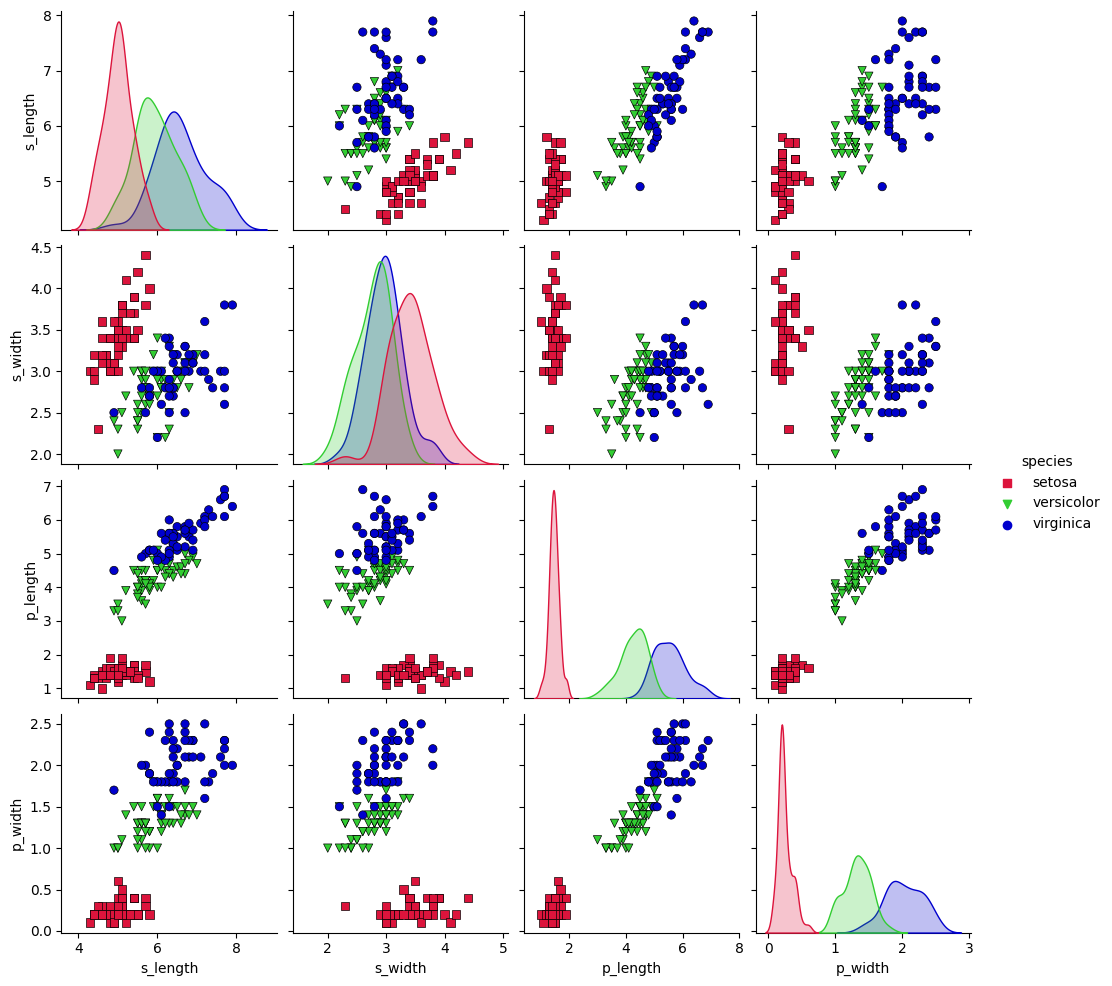

In [95]:
sns.pairplot(full_df, 
             hue = 'species', 
             markers = ['s', 'v', 'o'],
             plot_kws = {'edgecolor' : 'black'}, 
             palette = ['#DC143C', '#32CD32', '#0000CD'])

## Задание 2

In [96]:
cols = np.random.permutation(df.columns.values)[:2]

In [97]:
def show_scatter(ax, cols, targets, show_labels = False, title = None):

    target = np.unique(targets)

    if target.size == 2:
        colors = ['b', 'g']
        markers = ['s', 'o']
    else:
        colors = ['b','r','g']
        markers = ['s', 'v', 'o']      

    for l, c, m in zip(target, colors, markers):
        
        ax.scatter(df[cols[0]][iris.target == l],
                   df[cols[1]][iris.target == l],
                   c = c, 
                   marker = m,
                   label = iris.target_names[l], 
                   edgecolors = 'black')
        
    if show_labels:
        ax.set_xlabel(cols[0])
        ax.set_ylabel(cols[1])

    if title is not None:
        ax.set_title(title)


In [98]:
def show_plot(estimator, cols, targets, title = None, ax = None, custom = False):

    alpha = 0.5
    cmap = 'brg'

    if ax is None:
        ax = plt.axes()

    if not custom:
        DecisionBoundaryDisplay.from_estimator(estimator, 
                                            df[cols], 
                                            response_method = 'predict', 
                                            plot_method = 'pcolormesh', 
                                            ax = ax, 
                                            alpha = alpha, 
                                            cmap = cmap)
    else:
        x_min, x_max = df[cols[0]].min() - 1, df[cols[0]].max() + 1
        y_min, y_max = df[cols[1]].min() - 1, df[cols[1]].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

        Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha = alpha, cmap = cmap)

    show_scatter(ax, cols, targets)

    if title is not None:
        ax.set_title(title)

    ax.legend()
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])

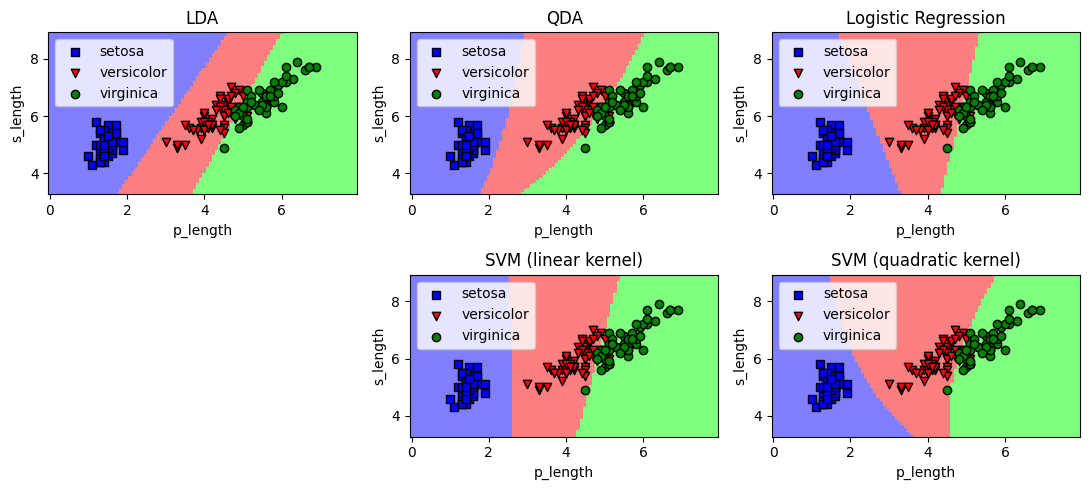

In [99]:
fig = plt.figure(layout = 'constrained')
gs = GridSpec(2, 3, figure = fig)

fig.set_figwidth(11)
fig.set_figheight(5)

models = [LDA(), QDA(), LogReg(), svm.SVC(kernel = 'linear'), svm.SVC(kernel = 'poly')]
titles = ['LDA', 'QDA', 'Logistic Regression', 'SVM (linear kernel)', 'SVM (quadratic kernel)']
gss = [gs[0, 0], gs[0, 1], gs[0, 2], gs[1, 1], gs[1, 2]]

for model, title, grid in zip(models, titles, gss):       

    ax = fig.add_subplot(grid)

    m = model.fit(df[cols], iris.target)
    show_plot(m, cols, iris.target, title, ax = ax)

plt.tight_layout()
plt.show()

# Задание 3

In [100]:
X = df[full_df['species'] != 'setosa']
Y = iris.target[full_df['species'] != 'setosa']

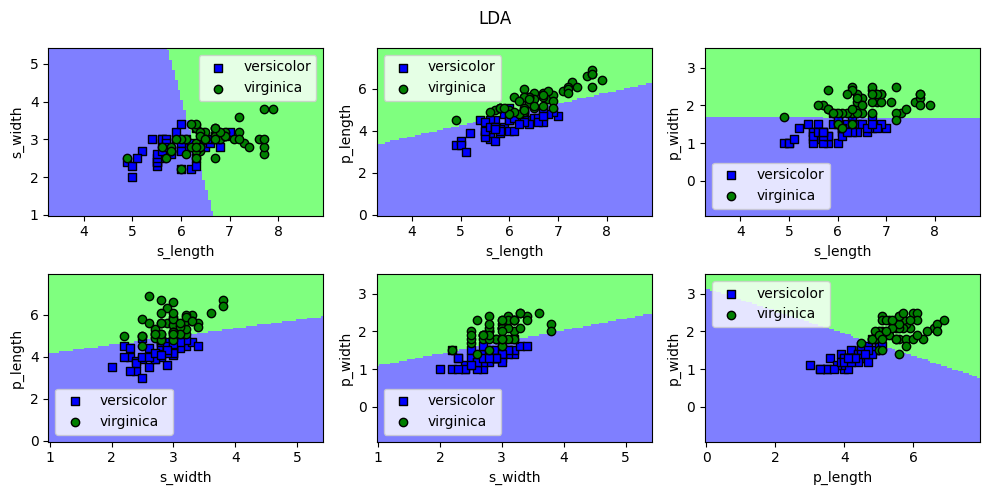

In [101]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(10)
fig.set_figheight(5)

for (col1, col2), ax in zip(combinations(X.columns.values, 2), axs.flatten()):       

    lda = LDA().fit(X[[col1, col2]], Y)
    show_plot(lda, [col1, col2], Y, ax = ax)

fig.suptitle('LDA')
plt.tight_layout()
plt.show()

# Задание 4

In [102]:
class my_QDA():

    def fit(self, x, y):
        
        self.feature = x.columns.values
        self.targets = y
        self.classes = np.unique(y)

        self.means = np.array([x[y == cls].mean(axis = 0) for cls in self.classes])
        self.covs = np.array([x[y == cls].cov() for cls in self.classes])
        self.inv_covs = np.array([np.linalg.inv(self.covs[cls]) for cls in self.classes])
        self.log_det = np.log10(np.linalg.det(self.inv_covs))

        return self
          
    def predict(self, x):
        
        f = []
        x = np.array(x)

        for k in range(len(self.classes)):

            x_mean = lambda i: np.array(x[i, :]) - self.means[k]

            f.append([np.log(np.matmul(x_mean(i), np.matmul(
                self.inv_covs[k], np.transpose(x_mean(i))))) + self.log_det[k] for i in range(len(x))])

        return np.argmin(f, axis = 0)

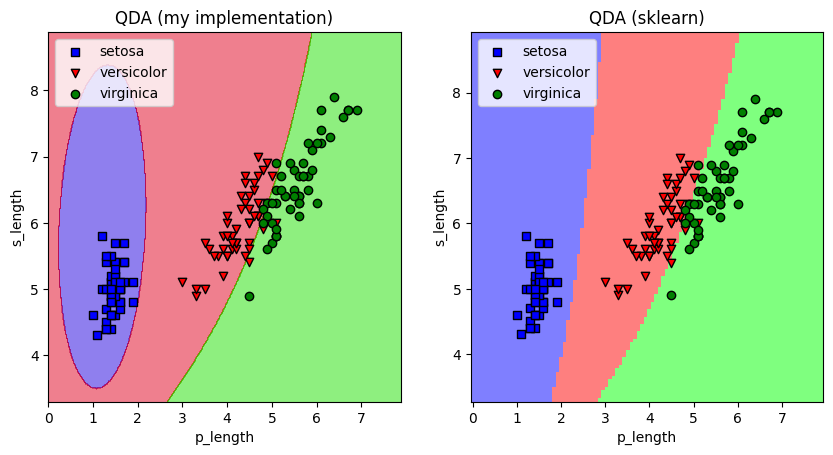

In [103]:
my_qda = my_QDA().fit(df[cols], iris.target)
qda = QDA().fit(df[cols], iris.target)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

show_plot(my_qda, cols, iris.target, ax = ax1, title = 'QDA (my implementation)', custom = True)
show_plot(qda, cols, iris.target, ax = ax2, title = 'QDA (sklearn)')